<a href="https://colab.research.google.com/github/ganeshbmc/GenAI_Math/blob/main/GAN_Conditional_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps  
1. Import libraries  
2. Prepare data  
   ```Download  |  Transform  |  Dataloader```  
3. Define parameters  
   ```Model  |  Optimizer  |  Loss  |  Training  ```
4. Build Model  
   ```Components  ```
5. Training loop  
6. Visualize results  

## Import libraries  

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

print(f"Imports completed at {datetime.datetime.now()}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Versions
print(f"Torch: {torch.__version__}, TorchVision: {torchvision.__version__}")

/home/jovyan/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-9puyt5wd because there was an issue with the default path (/home/jovyan/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No

Imports completed at 2025-08-21 10:30:01.031185
Using device: cuda
Torch: 2.5.1, TorchVision: 0.20.1


In [2]:
# Create output folder
folder_name = "cgan_mlp_generated_images"
os.makedirs(f"{folder_name}", exist_ok=True)

## Define parameters  

In [3]:
# Set seed for PyTorch
seed = 42
torch.manual_seed(seed)

# Data prep params
batch_size = 128

# Model params
z_dim = 100     # z_dim
img_shape = (1, 28, 28)         # MNIST size
num_classes = 10                # New parameter compared to Vanilla GAN

# Optimizer params
learning_rate = 0.
# beta1 = 0.5

# # Loss params
# criterion = nn.BCELoss()

# Training params
num_epochs = 20
generator_rounds = 1
discriminator_rounds = 1

In [4]:
# torch.prod(torch.tensor(img_shape))

## Prepare data  

In [5]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
print(f"Transform to be applied:\n{transform}\n")

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Train data:\n{train_dataset}\n")

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Last batch will be 96 (6000 % 128) instead of 128, so drop to avoid problem with batch norm
print(f"Data loader:\n{train_loader}")

Transform to be applied:
Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

Train data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Data loader:


## Build Model  
```Conditional GAN with MLP```  
- MLP as neural network  

Generator
- noise_dim -> hidden layers -> img_dim with ReLU and Tanh  

Discriminator
- img_dim -> hidden layers -> 1 with Sigmoid activation  

In [6]:
# Generator
class Generator(nn.Module):
  def __init__(self, z_dim, num_classes, img_shape):
    super(Generator, self).__init__()
    # Set input dimension to include class information. Add Embedding layer to make params learnable.
    self.label_emb = nn.Embedding(num_classes, num_classes)
    self.img_shape = img_shape
    input_dim = z_dim + num_classes

    self.model = nn.Sequential(
        # MLP
        nn.Linear(input_dim, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(True),

        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(True),

        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(True),

        nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
        nn.Tanh()   # Because we normalized images to [-1, 1]
    )

  def forward(self, z, labels):
    # Concatenate noise and label embedding
    x = torch.cat([z, self.label_emb(labels)], dim=1)
    img = self.model(x)   # Output shape (784,)
    img = img.view(x.size(0), *self.img_shape)  # Output shape (1, 28, 28)
    return img

In [7]:
generator = Generator(z_dim=z_dim, num_classes=num_classes, img_shape=img_shape).to(device)
generator

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

In [8]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self, num_classes, img_shape):
    super(Discriminator, self).__init__()
    self.label_emb = nn.Embedding(num_classes, num_classes)
    input_dim = int(torch.prod(torch.tensor(img_shape))) + num_classes

    self.model = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Linear(256, 1),
        nn.Sigmoid()    # Outputs probability between 0 and 1
    )

  def forward(self, img, labels):
    # Flatten the image and concatenate label
    img_flat = img.view(img.size(0), -1)
    x = torch.cat([img_flat, self.label_emb(labels)], dim=1)
    return self.model(x)

In [9]:
discriminator = Discriminator(num_classes, img_shape).to(device)
discriminator

Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Set up Optimizers  

In [10]:
g_optim = optim.Adam(generator.parameters(), lr=learning_rate)
g_optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0
    maximize: False
    weight_decay: 0
)

In [11]:
d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)
d_optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0
    maximize: False
    weight_decay: 0
)

## Set up Loss functions  

In [12]:
criterion = nn.BCELoss()
criterion

BCELoss()

## Code for visualizations  

In [13]:
# def show_generated_images(epoch, generator, fixed_noise):
#     generator.eval()
#     with torch.no_grad():
#         fake_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
#         fake_imgs = fake_imgs * 0.5 + 0.5  # De-normalize

#     grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
#     plt.figure(figsize=(8,8))
#     plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
#     plt.title(f'Generated Images at Epoch {epoch}')
#     plt.axis('off')
#     plt.show()
#     generator.train()

In [14]:
def save_n_show_generated_images(epoch, generator, folder_name=folder_name):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(10, z_dim, device=device)
        labels = torch.arange(0, 10, dtype=torch.long, device=device)   # Create 
        samples = generator(z, labels)
        samples = samples * 0.5 + 0.5  # Denormalize

        # Save the images
        save_image(samples, f"{folder_name}/epoch_{epoch}.png", nrow=10)

        # Display the images
        grid = torchvision.utils.make_grid(samples, nrow=10)
        plt.figure(figsize=(15, 3))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f'Generated Digits (Epoch {epoch})')
        plt.axis('off')
        plt.show()

    generator.train()

## Training loop  
- Visualize results every 10 epochs  

In [15]:
def gan_trainer(train_loader, num_epochs=20, discriminator_rounds=1, generator_rounds=1):
  # Training loop
  for epoch in range(num_epochs):
    for batch_idx, (real_images, real_class_labels) in enumerate(train_loader):  # We will be using MNIST class labels for conditional GAN training
      batch_size = real_images.size(0)
      real_images = real_images.to(device)
      real_class_labels = real_class_labels.to(device)

      ## Create real and fake labels (note that these are not MNIST class labels. Just labels which tell if image is fake or real)
      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      ### ====================================
      ### 1. Train Discriminator
      ### ====================================
      for _ in range(discriminator_rounds):
        # Real images and loss
        outputs = discriminator(real_images, real_class_labels)
        d_loss_real = criterion(outputs, real_labels)

        # Fake images and loss
        z = torch.randn(batch_size, z_dim).to(device)
        fake_class_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        with torch.no_grad():
          fake_images = generator(z, fake_class_labels)
        outputs = discriminator(fake_images.detach(), fake_class_labels)    # Detach so gradients don't flow into generator
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake

        # Update Discriminator params
        discriminator.zero_grad()
        d_loss.backward()
        d_optim.step()

      ### ====================================
      ### 2. Train Generator
      ### ====================================
      for _ in range(generator_rounds):
        # Generate fake images again
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_images = generator(z, gen_labels)

        # Try to fool the discriminator
        outputs = discriminator(gen_images, gen_labels)
        g_loss = criterion(outputs, real_labels)  # trick discriminator [# want D(G(z)) = 1]

        # Update Generator params
        generator.zero_grad()
        g_loss.backward()
        g_optim.step()


    # Visualize
    if (epoch+1) % 10 == 0:
      print(f"Epoch: [{epoch+1}/{num_epochs}]")
      print(f"Size of real images: {real_images.size()}")
      print(f"Discriminator loss = {d_loss.item():.4f}")
      print(f"Generator loss = {g_loss.item():.4f}")
      save_n_show_generated_images(epoch=epoch+1, generator=generator)

## Training  

Epoch: [10/20]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = 1.4227
Generator loss = 0.7147


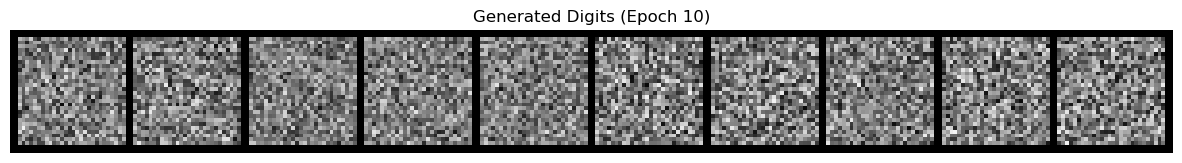

Epoch: [20/20]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = 1.4182
Generator loss = 0.7150


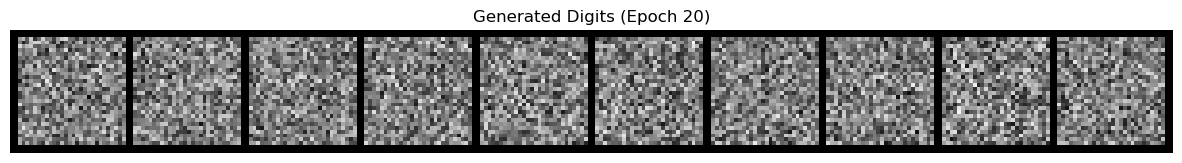

In [16]:
gan_trainer(train_loader,
            num_epochs=num_epochs,
            discriminator_rounds=discriminator_rounds,
            generator_rounds=generator_rounds
            )